<a href="https://colab.research.google.com/github/lych0508/Projects/blob/main/Manufacturing_Processing_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Overview

The dataset represents different permutations of Mercedes-Benz car features to predict the time it takes to pass testing. I will tackle the curse of dimensionality and reduce the time that cars spend on the test bench. An excellent solution can contribute to speedier testing, resulting in lower carbon dioxide emissions without reducing Daimler's standards

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
#from sklearn.externals import joblib

# 1. Data Exploration
* Rough overview of the data
* Check missing, duplicated values
* Target and feature distribution, including outliers and patterns
* Understand the meaning of each faeture, their types, correlation etc.

## 1.1 Load data

In [2]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
#Load train data
link = 'https://drive.google.com/open?id=1rRV40omvIJ6hz_Ygj5oMDo9wgLDgW14w'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) # replace the id with id of file you want to access
file.GetContentFile('train.csv')  
# Read file as panda dataframe
train = pd.read_csv('train.csv')


In [4]:
#Load test data
link = 'https://drive.google.com/open?id=1WSLG53RxfybQNmTzXFwa7c-JEUDexG5t'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) # replace the id with id of file you want to access
file.GetContentFile('test.csv')  
# Read file as panda dataframe
test = pd.read_csv('test.csv')

In [5]:
print("Train data shape : ", train.shape)
print("Test data shape : ", test.shape)

Train data shape :  (4209, 378)
Test data shape :  (4209, 377)


There are 376 features in the dataset

In [6]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


The training dataset includes both numeric and object data. 

##1.2 Exploratory Data Analysis

In [8]:
# missing value, duplicated value
print ('missing value =', train.isnull().sum().sum())
print ('duplicated rows =', train.duplicated().sum())
print ('duplicated columns=',train.columns.duplicated().sum())

missing value = 0
duplicated rows = 0
duplicated columns= 0


In [9]:
# data type
print (train.info(),'\n')
# y statistics

print ('Basic statistics of target y\n',train['y'].describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB
None 

Basic statistics of target y
 count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64


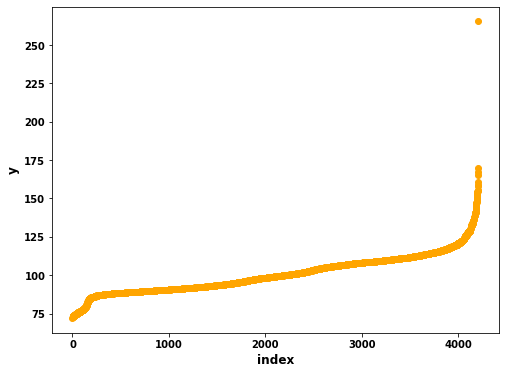

In [10]:
# check target y
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train['y'].values), color='orange')
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

The minimum value of y is 72 and the maximum value of y is 265. Then I draw a graph to see the trend of y. The distribution is pretty smooth except one point y = 265. Since it increase around 30% suddently and it is only one out of 4000 points, I treat it as a outlier. 

In [11]:
#drop outlier
train.drop(train.index[train['y'] == '265'], inplace=True)
train['y'].describe()

count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


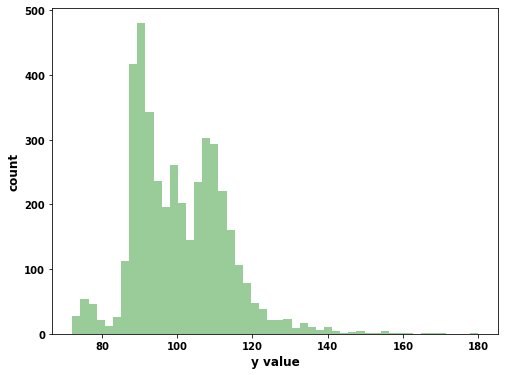

In [12]:
# distribution of y
ulimit = 180
train['y'].iloc[train['y']>ulimit] = ulimit

plt.figure(figsize=(8,6))
sns.distplot(train['y'].values, bins=50, kde=False, color='green')
plt.xlabel('y value', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.show()

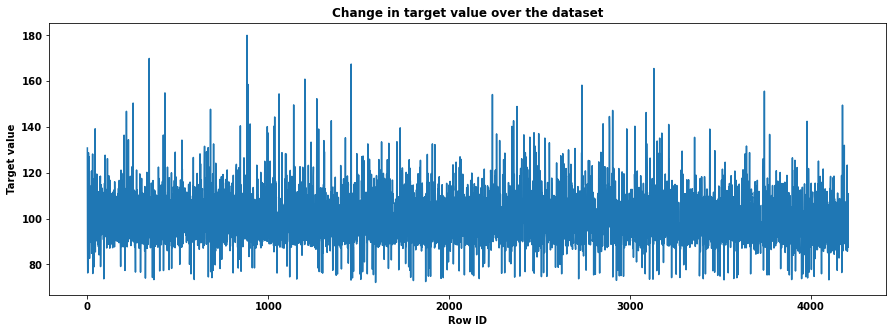

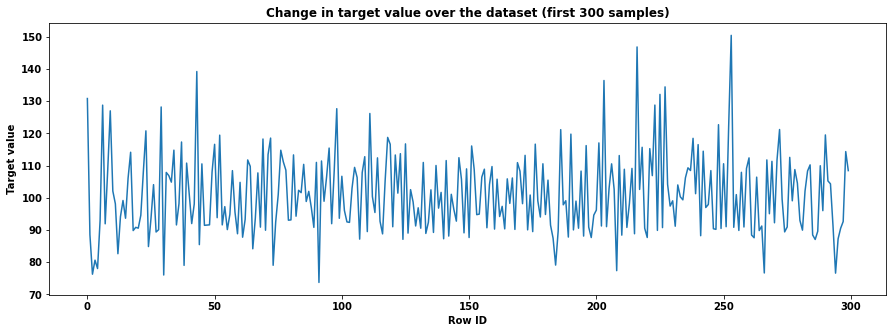

In [13]:
# correlation of ID in train and test, if a sequence pattern can be observed
plt.figure(figsize=(15, 5))
plt.plot(train['y'])
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset', fontweight='bold')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(train['y'].values[:300])
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset (first 300 samples)', fontweight='bold')
print()

There is no trend between RowID and target value.

# 2. Feature Engineering
* High dimension feature need to be taken care of
* Check duplicated and constant feaeture
* Check low count categorical features
* Principal Component Analysis, Independent Component Analysis, Truncated SVD are common methods

##2.1 Categorical Features

In [14]:
# Categorical features
cat_cols = []
for c in train.columns:
    if train[c].dtype == 'object':
        cat_cols.append(c)
print('Categorical columns:', cat_cols)

# Dublicate features
d = {}; done = []
cols = train.columns.values
for c in cols: 
    d[c]=[]
for i in range(len(cols)):
    if i not in done:
        for j in range(i+1, len(cols)):
            if all(train[cols[i]] == train[cols[j]]):
                done.append(j)
                d[cols[i]].append(cols[j])
dub_cols = []
for k in d.keys():
    if len(d[k]) > 0: 
        # print k, d[k]
        dub_cols += d[k]        
print('Dublicates:', dub_cols)

# Constant columns
const_cols = []
for c in cols:
    if len(train[c].unique()) == 1:
        const_cols.append(c)
print('Constant cols:', const_cols)

col_del = dub_cols+const_cols # these features can be deleted

Categorical columns: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']
Dublicates: ['X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347', 'X382', 'X232', 'X279', 'X35', 'X37', 'X39', 'X302', 'X113', 'X134', 'X147', 'X222', 'X102', 'X214', 'X239', 'X76', 'X324', 'X248', 'X253', 'X385', 'X172', 'X216', 'X213', 'X84', 'X244', 'X122', 'X243', 'X320', 'X245', 'X94', 'X242', 'X199', 'X119', 'X227', 'X146', 'X226', 'X326', 'X360', 'X262', 'X266', 'X247', 'X254', 'X364', 'X365', 'X296', 'X299']
Constant cols: ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']


There are 8 categorical data and the rest are binary data. I found there is missing X 7 feature. The  Mercedes-Benz said this X 7 is reserved for a future flagship model. In this dataset, X 7 has not been tested, so they ignore this feature. 

I also check the dulpilicate columns. These features have extactly same values with another feature. Moreover, I check the constant columns which means the values of this feature do not change all the time. I will delete these useless columns in the future steps

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

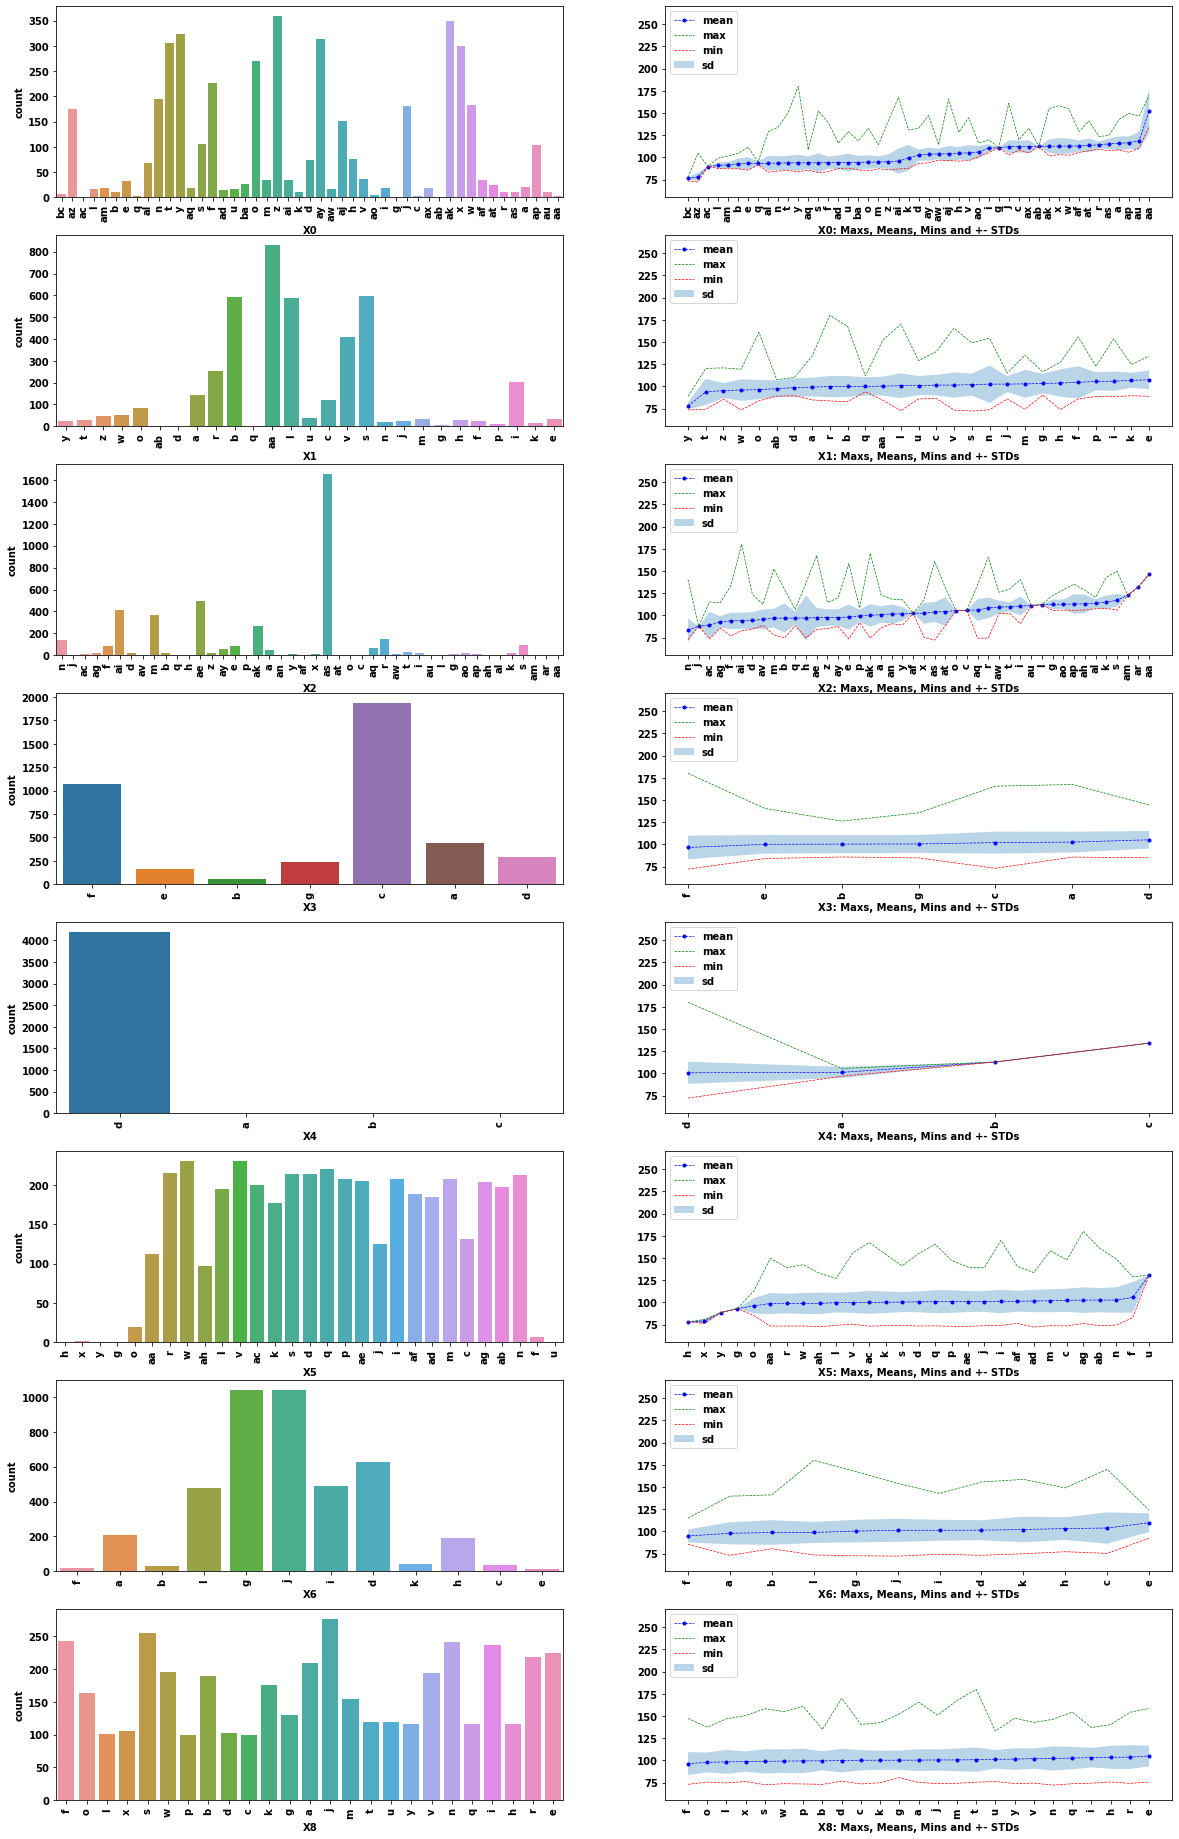

In [15]:
# check for low count sub-categories in category features
plt.figure(figsize=(20,33)) 
for i in range(len(cat_cols)):
    c = cat_cols[i]
    means = train.groupby(c).y.mean()
    stds = train.groupby(c).y.std().fillna(0)
    maxs = train.groupby(c).y.max()
    mins = train.groupby(c).y.min()
    
    ddd = pd.concat([means, stds, maxs, mins], axis=1); 
    ddd.columns = ['means', 'stds', 'maxs', 'mins']
    ddd.sort_values('means', inplace=True)
    
    plt.subplot(8,2,2*i+1)
    ax = sns.countplot(train[c], order=ddd.index.values)
    plt.xticks(rotation=90)
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
#         ax.annotate('{:.0f}'.format(y), (x.mean(), y), ha='center', va='bottom')

    plt.subplot(8,2,2*i+2)
    plt.fill_between(range(len(train[c].unique())), 
                     ddd.means.values - ddd.stds.values,
                     ddd.means.values + ddd.stds.values,
                     alpha=0.3, label='sd'
                    )
    plt.xticks(range(len(train[c].unique())), ddd.index.values,rotation=90)
    plt.plot(ddd.means.values, color='b', marker='.', linestyle='dashed', linewidth=0.7, label ='mean')
    plt.plot(ddd.maxs.values, color='g', linestyle='dashed', linewidth=0.7,label ='max')
    plt.plot(ddd.mins.values, color='r', linestyle='dashed', linewidth=0.7, label='min')
    plt.legend(loc='upper left')
    plt.xlabel(c + ': Maxs, Means, Mins and +- STDs')
    plt.ylim(55, 270)
    


I noticed some feature has many sub-categories, for example X0 has more than 40 sub categories. In order to reduce the dimensions, I will combine the less frequent sub features (<1%) with 'uncommon'

In [16]:
# combine train and test
train['if_train'] = 1; test['if_train'] = 0
df = pd.concat([train, test], axis=0, copy=True, sort=False)
# Reset index
df.reset_index(drop=True, inplace=True)

In [17]:
# delete constant and duplicated columns
df_1 = df.drop(columns=col_del)

In [19]:
# fill all the less frequent categorical sub-features  (<1%) with 'uncommon'
# this is optional, proceed with caution, what's the risk?
for item in cat_cols:
    try:
        counts = df_1[item].value_counts()
        list_less = counts[counts <= 85].index # <1% of total
        tmp1 = df_1[item].replace(list_less, 'uncommon')
        tmp1= pd.DataFrame(tmp1)
        df_1 = pd.concat([tmp1, df_1.drop([item], axis =1)], axis =1)
    except:
        pass

In [20]:
# label encoding the categorical features for dimension reduction
# label encoding vs. one-hot encoding? 
for c in df_1.columns:
    if df_1[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(df_1[c].values))
        df_1[c] = lbl.transform(list(df_1[c].values))

In [21]:
# seperate train and test
df_1.set_index('ID', inplace=True)
df_train = df_1[df_1['if_train']==1]
df_test = df_1[df_1['if_train']==0]

In [34]:
df_train.head()


,X8,X6,X5,X4,X3,X2,X1,X0,y,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X36,X38,X40,X41,X42,X43,X44,X45,...,X340,X341,X342,X343,X344,X345,X346,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X361,X362,X363,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X383,X384,if_train
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,14,5,20,0,0,13,10,14,130.81,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
6,14,7,20,0,4,13,9,14,88.53,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
7,23,5,20,0,2,10,11,5,76.26,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,4,7,20,0,5,10,9,5,80.62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
13,13,1,20,0,5,10,10,5,78.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [35]:
df_test.head()

,X8,X6,X5,X4,X3,X2,X1,X0,y,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X36,X38,X40,X41,X42,X43,X44,X45,...,X340,X341,X342,X343,X344,X345,X346,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X361,X362,X363,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X383,X384,if_train
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22,0,20,0,5,10,10,5,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,24,2,20,0,0,2,2,13,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,9,5,20,0,5,5,10,5,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,13,7,20,0,5,10,5,5,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,12,4,20,0,2,5,8,15,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


##2.2 Dimensionality Reduction

In [24]:
# feature reduction methods
# tried back and forth, using 20-30 reduced component with heighest evaluation number
n_comp = 20 # a hyper-parameter 

# tSVD, what's the difference bewteen PCA and SVD?   Contrary to PCA, this estimator does not center the data before computing the singular value decomposition.
tsvd = TruncatedSVD(n_components=n_comp, random_state=2061)
tsvd_results_train = tsvd.fit_transform(df_train.drop(['y','if_train'], axis=1))
tsvd_results_test = tsvd.transform(df_test.drop(['y','if_train'], axis=1))

# PCA - combines input variables in a specific way, then we can drop the “least important” variables while still retaining the most valuable parts of all of the variables
pca = PCA(n_components=n_comp, random_state=2061)
pca2_results_train = pca.fit_transform(df_train.drop(['y','if_train'], axis=1))
pca2_results_test = pca.transform(df_test.drop(['y','if_train'], axis=1))

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=2061)
srp_results_train = srp.fit_transform(df_train.drop(['y','if_train'], axis=1))
srp_results_test = srp.transform(df_test.drop(['y','if_train'], axis=1))


(-0.1, 21.0)

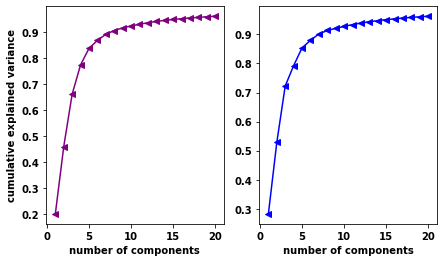

In [25]:
# n_components is a hyper-paramter, in SVD and PCA, variance ratio curve is shown
plt.figure(figsize=(7,4))
plt.subplot(121)
plt.plot(np.arange(1,21),np.cumsum(tsvd.explained_variance_ratio_), color='purple',marker='<')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xlim((-0.1,21))

plt.subplot(122)
plt.plot(np.arange(1,21),np.cumsum(pca.explained_variance_ratio_), color='blue', marker='<')
plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
plt.xlim((-0.1,21))

# 3. Model Selection


In [26]:
from sklearn.utils import shuffle
# splite train dataset into train(80%) and valid (20%) set
y_train = df_train['y'].values

tsvd_train, tsvd_valid, y_tsvd_train, y_tsvd_valid = train_test_split(srp_results_train, y_train, 
                                                                      test_size=0.2, random_state=2061)

XGBoost stands for eXtreme Gradient Boosting.XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. It is both a linear model solver and a tree learning algorithm. It does a parallel computation on a single machihne, and supports various objective functions including regression, classification and ranking.

Two reason to use XGBoost - fast execution and better performance which are alagin with the goals of the project.

In [27]:
gridsearch_params = [
    (eta, subsample,n_trees, max_depth)
    for eta in [0.03, 0.05, 0.07] 
    for subsample in [0.5,0.6,0.7]
    for n_trees in [200,300,400]
    for max_depth in [3,4,5]
]

gridsearch_params

def xgb_r2_score(preds,dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

In [28]:
param = {}
max_r2 = float("-inf")
best_params = None

xg_train = xgb.DMatrix(tsvd_train, label=y_tsvd_train)

for eta, subsample, n_trees, max_depth in (gridsearch_params):
    print("CV with eta={},subsample ={}, n_trees={}, max_depth={}".format(eta,subsample,n_trees,max_depth))
    param['objective'] = 'reg:linear'
    param['max_depth'] = max_depth
    param['n_trees'] = n_trees
    param['eta'] = eta
    param['subsample'] = subsample
    param['nthread'] = 12
    param['verbosity'] = 0

    cv_results = xgb.cv(
        param,
        xg_train,
        seed=2061,
        nfold=3,
        num_boost_round = 600,
        early_stopping_rounds=10, 
        feval = xgb_r2_score,
        show_stdv=False
    )

    mean_r2 = cv_results['test-r2-mean'].max()
    if mean_r2 > max_r2:
        max_r2 = mean_r2
        best_params = (eta, subsample, n_trees, max_depth)

print("Best params: eta{},subsample{},n_trees{},max_depth{}, r2: {}".format(best_params[0], best_params[1],best_params[2],best_params[3], max_r2))

CV with eta=0.03,subsample =0.5, n_trees=200, max_depth=3
CV with eta=0.03,subsample =0.5, n_trees=200, max_depth=4
CV with eta=0.03,subsample =0.5, n_trees=200, max_depth=5
CV with eta=0.03,subsample =0.5, n_trees=300, max_depth=3
CV with eta=0.03,subsample =0.5, n_trees=300, max_depth=4
CV with eta=0.03,subsample =0.5, n_trees=300, max_depth=5
CV with eta=0.03,subsample =0.5, n_trees=400, max_depth=3
CV with eta=0.03,subsample =0.5, n_trees=400, max_depth=4
CV with eta=0.03,subsample =0.5, n_trees=400, max_depth=5
CV with eta=0.03,subsample =0.6, n_trees=200, max_depth=3
CV with eta=0.03,subsample =0.6, n_trees=200, max_depth=4
CV with eta=0.03,subsample =0.6, n_trees=200, max_depth=5
CV with eta=0.03,subsample =0.6, n_trees=300, max_depth=3
CV with eta=0.03,subsample =0.6, n_trees=300, max_depth=4
CV with eta=0.03,subsample =0.6, n_trees=300, max_depth=5
CV with eta=0.03,subsample =0.6, n_trees=400, max_depth=3
CV with eta=0.03,subsample =0.6, n_trees=400, max_depth=4
CV with eta=0.

In [29]:
best_params

(0.03, 0.6, 200, 5)

In [39]:
cv_results.head()

,train-r2-mean,train-r2-std,train-rmse-mean,train-rmse-std,test-r2-mean,test-r2-std,test-rmse-mean,test-rmse-std
0,-57.379909,1.035561,93.860064,0.068613,-57.438041,2.150747,93.855759,0.149865
1,-49.616469,0.900291,87.396667,0.063414,-49.665815,1.876829,87.391444,0.157692
2,-42.904597,0.778297,81.396205,0.058027,-42.944640,1.638064,81.388428,0.158652
3,-37.105771,0.668982,75.830719,0.045797,-37.150697,1.435669,75.833020,0.164702
4,-32.070286,0.570758,70.643122,0.030020,-32.107406,1.262919,70.642479,0.178788


#4. Evaluation

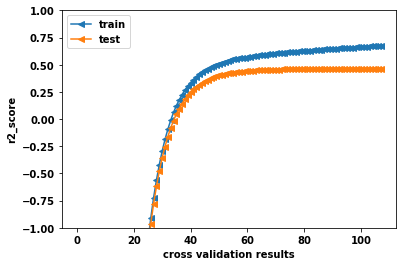

In [38]:
# change of r2 in train and valid data 
plt.plot(cv_results['train-r2-mean'], marker='<',label = 'train')
plt.plot(cv_results['test-r2-mean'],marker='<', label = 'test')
plt.ylim(-1,1)
plt.xlabel('cross validation results')
plt.ylabel('r2_score')
plt.legend(loc='upper left')
plt.show()


In [40]:
d_train = xgb.DMatrix(tsvd_train, label=y_tsvd_train)
d_valid = xgb.DMatrix(tsvd_valid, label=y_tsvd_valid)
#best_params = (eta, subsample, n_trees, max_depth)

xgb_params = {
    'n_trees': best_params[2], 
    'eta': best_params[0],
    'max_depth': best_params[3],
    'subsample': best_params[1],
    'objective': 'reg:linear',
    'base_score': np.mean(y_tsvd_train), # base prediction = mean(target)
    'silent': 1
}

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

best_model = xgb.train(xgb_params, d_train, 6000 , watchlist, early_stopping_rounds=70, feval=xgb_r2_score, maximize=True, verbose_eval=10)

[0]	train-rmse:12.1575	valid-rmse:13.1039	train-r2:0.020873	valid-r2:0.018501
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 70 rounds.
[10]	train-rmse:11.072	valid-rmse:12.0078	train-r2:0.187917	valid-r2:0.175838
[20]	train-rmse:10.3271	valid-rmse:11.2836	train-r2:0.293504	valid-r2:0.27225
[30]	train-rmse:9.79082	valid-rmse:10.7827	train-r2:0.364976	valid-r2:0.335424
[40]	train-rmse:9.36309	valid-rmse:10.4148	train-r2:0.419249	valid-r2:0.38
[50]	train-rmse:9.061	valid-rmse:10.1738	train-r2:0.456119	valid-r2:0.408371
[60]	train-rmse:8.8313	valid-rmse:10.0274	train-r2:0.483345	valid-r2:0.425275
[70]	train-rmse:8.64405	valid-rmse:9.88815	train-r2:0.505022	valid-r2:0.441123
[80]	train-rmse:8.5023	valid-rmse:9.81635	train-r2:0.521122	valid-r2:0.44921
[90]	train-rmse:8.39792	valid-rmse:9.77027	train-r2:0.532808	valid-r2:0.454369
[100]	train-rmse:8.28922	valid-rmse:9.73322	train-r2:0.544825	valid-r2:0.458499
[

Both train and validation's r-square do not improve after 70 rounds

##4.1 Feature Importance

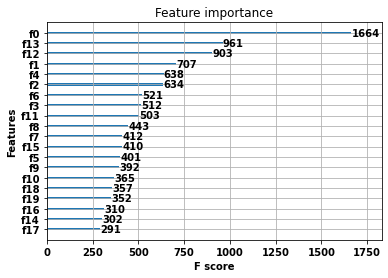

In [41]:
# SVD component f0 is also the one with highest feature importance, but f1 is the next one
#These are not the the origional features, but they are after dimension reduction features.
xgb.plot_importance(best_model)

In [42]:
# save model
import joblib
model_name = 'best_model_3_12.sav'
joblib.dump(best_model, model_name) # 'compress' can be used if model is large

['best_model_3_12.sav']

# 5. Prediction

In [43]:
d_predict = xgb.DMatrix(tsvd_results_test)
ypred = best_model.predict(d_predict)
# ypred.to_csv('predict.csv')
